## Setup

### Libraries and Helper Functions


In [ ]:
#@title Imports

import numpy as np
import pandas as pd
import sklearn as sk
import os
import nltk
from nltk.data import find
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#@title Utility print function

def print_version(library_name):
    try:
        lib = __import__(library_name)
        version = getattr(lib, '__version__', 'Version number not found')
        print(f"{library_name} version: {version}")
    except ImportError:
        print(f"{library_name} not installed.")
    except Exception as e:
        print(f"An error occurred: {e}")

#confirm versions
print_version('numpy')
print_version('pandas')
print_version('sklearn')

numpy version: 1.26.4
pandas version: 2.1.4
sklearn version: 1.3.2


In [ ]:
#@title Utility Plot Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

In [ ]:
#@title Globals

#@title Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# Base path to store trained snapshot and results
BASE_PATH = 'drive/MyDrive/MIDS-266/w266/project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Read Reddit dataset into a dataframe
rdt_trainfile = f'{BASE_PATH}Reddit/both_train.csv'
rdt_tesstfile = f'{BASE_PATH}Reddit/both_test.csv'
rdt_valfile = f'{BASE_PATH}Reddit/both_val.csv'

rdt_train = pd.read_csv(rdt_trainfile)
rdt_test = pd.read_csv(rdt_tesstfile)
rdt_val = pd.read_csv(rdt_valfile)

# Shuffle all rows
rdt_train = rdt_train.sample(frac=1).reset_index(drop=True)
rdt_test = rdt_test.sample(frac=1).reset_index(drop=True)

train_labels = rdt_train.class_id
test_labels = rdt_test.class_id
val_labels = rdt_val.class_id

train_examples = rdt_train.post
test_examples = rdt_test.post
val_examples = rdt_val.post

In [ ]:
!ls

drive  sample_data


In [ ]:
mh_cls_names = list(rdt_train.class_name.unique())
mh_cls_names

['anxiety', 'depression', 'ptsd', 'bipolar', 'adhd', 'none']

In [ ]:
mh_cls_id = rdt_train.class_id.unique().tolist()
mh_cls_id

[1, 3, 4, 2, 0, 5]

In [ ]:
type(mh_cls_id)

list

In [ ]:
mh_dict_id_to_name = {}
mh_dict_name_to_id = {}
for idx, value in enumerate(mh_cls_id):
    mh_dict_id_to_name[value] = mh_cls_names[idx]
for idx, value in enumerate(mh_cls_names):
    mh_dict_name_to_id[value] = mh_cls_id[idx]

mh_dict_id_to_name
mh_dict_name_to_id

{'anxiety': 1, 'depression': 3, 'ptsd': 4, 'bipolar': 2, 'adhd': 0, 'none': 5}

In [ ]:
freqcount = np.zeros((6,7), dtype=int)
uncounted = 0
# Rules:
# If token matches the query class name, then note the query class name and actual class-id where the token was found
# If token does not match the query class name, then note the actual class-id where token was not found
for name in mh_cls_names:
    m_id = mh_dict_name_to_id[name]
    # For each class, check to see if the name exists in the text. If it does, then
    # increment the relevant matrix count
    for i in range(len(rdt_train)):
        # Tokenize the text
        text = rdt_train.title[i] + rdt_train.post[i]
        tokens = word_tokenize(text.lower())  # Convert to lowercase to count words in a case-insensitive manner
        # Get class name of text
        cls = rdt_train.class_name[i]
        clsid = rdt_train.class_id[i]
        if name in tokens:
          if name != 'none':
            freqcount[m_id][clsid] += 1
          else:
            uncounted += 1
        else:
          if m_id == clsid:
            freqcount[m_id][6] += 1


print(f'Uncounted: {uncounted}')



Uncounted: 257


In [ ]:
rdt_train.class_id.value_counts()

,count
class_id,
0,2465
3,2450
1,2422
2,2407
4,2001
5,1982


In [ ]:
np.sum(freqcount, axis=1)

array([2528, 3396, 2488, 3447, 2065, 1955])

In [ ]:
freqcount

array([[1285,   10,   38,    5,    8,    2, 1180],
       [ 214, 1514,  256,  202,  293,    9,  908],
       [  22,   15,  847,   12,   31,    1, 1560],
       [ 165,  197,  447,  779,  172,   16, 1671],
       [   4,   23,   26,   11, 1019,    0,  982],
       [   0,    0,    0,    0,    0,    0, 1955]])

In [ ]:
freqpct = freqcount/np.sum(freqcount, axis=1, keepdims=True)
freqpct = np.round(freqpct, decimals=2)
freqpct = freqpct*100
freqpct = freqpct.astype(int)
freqpct

array([[ 51,   0,   2,   0,   0,   0,  47],
       [  6,  45,   8,   6,   9,   0,  27],
       [  1,   1,  34,   0,   1,   0,  63],
       [  5,   6,  13,  23,   5,   0,  48],
       [  0,   1,   1,   1,  49,   0,  48],
       [  0,   0,   0,   0,   0,   0, 100]])

In [ ]:
#@title Occurance of classnames in text content belonging to different labels

print(f'Labeled class:\t       ', end='')
for mh in mh_cls_names:
  print(f'{mh}  ', end='')
print('absent in post')
print('')

for mh1 in mh_cls_id:
  print(f'Token {mh_dict_id_to_name[mh1]:<17s}\t', end='')
  for mh2 in mh_cls_id:
    word2 = mh_dict_id_to_name[mh2]
    print(f'{freqpct[mh1][mh2]}%', end='\t')
  print(f'{freqpct[mh1][6]}%')


Labeled class:	       anxiety  depression  ptsd  bipolar  adhd  none  absent in post

Token anxiety          	45%	6%	9%	8%	6%	0%	27%
Token depression       	6%	23%	5%	13%	5%	0%	48%
Token ptsd             	1%	1%	49%	1%	0%	0%	48%
Token bipolar          	1%	0%	1%	34%	1%	0%	63%
Token adhd             	0%	0%	0%	2%	51%	0%	47%
Token none             	0%	0%	0%	0%	0%	0%	100%


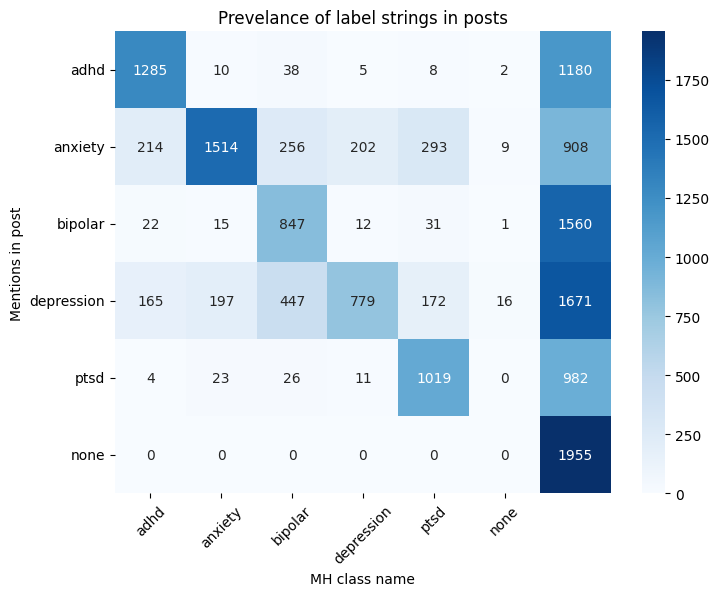

In [ ]:

# Plot the confusion matrix
mh_class_names = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]
text_mentions = [mh_dict_id_to_name[i] for i in range(len(mh_cls_names))]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(freqcount, annot=True, fmt='d', cmap='Blues')

# Add string labels to the axes
plt.xticks(ticks=np.arange(len(mh_class_names)) + 0.5, labels=mh_class_names, rotation=45)
plt.yticks(ticks=np.arange(len(text_mentions)) + 0.5, labels=text_mentions, rotation=0)

# Add labels, title, and color bar
plt.xlabel('MH class name')
plt.ylabel('Mentions in post')
plt.title('Prevelance of label strings in posts')
plt.show()

In [ ]:
#@title Inspect data and label characteristics

print(f'Training set labels shape: {train_labels.shape}')
print(f'Test set labels shape: {test_labels.shape}')

print(f'Training set examples shape: {train_examples.shape}')
print(f'Test set examples shape: {test_examples.shape}')

print(f'Distribution of the length of all title')
print(rdt_train["title"].str.len().describe())

print('Distribution of the length of all posts')
print(rdt_train["post"].str.len().describe())

print(f'Labels min : {rdt_train.class_id.min()} max : {rdt_train.class_id.max()}')


Training set labels shape: (13727,)
Test set labels shape: (1488,)
Training set examples shape: (13727,)
Test set examples shape: (1488,)
Distribution of the length of all title
count    13727.000000
mean        67.111751
std         48.713468
min          2.000000
25%         34.000000
50%         54.000000
75%         85.000000
max        306.000000
Name: title, dtype: float64
Distribution of the length of all posts
count    13727.000000
mean      1065.297734
std       1373.414370
min        123.000000
25%        362.000000
50%        658.000000
75%       1236.500000
max      38168.000000
Name: post, dtype: float64
Labels min : 0 max : 5


In [ ]:
#@title Distribution of labels in training and test sets
print(f'Training set')
for i in range(np.max(train_labels)+1):
  pos_indices = np.where(train_labels == i)
  pct_positive = len(pos_indices[0])*100/len(train_labels)
  print(f'Label {mh_dict_id_to_name[i]} in training set  : {len(pos_indices[0])}/{len(train_labels)} ({pct_positive:02.02f}%)')

print(f'\nValidation set')
for i in range(np.max(val_labels)+1):
  pos_indices = np.where(val_labels == i)
  pct_positive = len(pos_indices[0])*100/len(val_labels)
  print(f'Label {mh_dict_id_to_name[i]} in validation set: {len(pos_indices[0])}/{len(val_labels)} ({pct_positive:02.02f}%)')


Training set
Label adhd in training set  : 2465/13727 (17.96%)
Label anxiety in training set  : 2422/13727 (17.64%)
Label bipolar in training set  : 2407/13727 (17.53%)
Label depression in training set  : 2450/13727 (17.85%)
Label ptsd in training set  : 2001/13727 (14.58%)
Label none in training set  : 1982/13727 (14.44%)

Validation set
Label adhd in validation set: 248/1488 (16.67%)
Label anxiety in validation set: 248/1488 (16.67%)
Label bipolar in validation set: 248/1488 (16.67%)
Label depression in validation set: 248/1488 (16.67%)
Label ptsd in validation set: 248/1488 (16.67%)
Label none in validation set: 248/1488 (16.67%)


In [ ]:
#@title Experiment to remove classname keywords in the train/test dataset

def mask_class_names(df):
  words = ['adhd', 'depression', 'ptsd', 'anxiety', 'bipolar']
  pattern = '|'.join(map(re.escape, words))
  print(pattern)
  count = df['post'].str.count(pattern).sum()
  print(f'Number of classnames in post: {count}')
  df['post'] = df['post'].str.replace(pattern, 'mask1', regex=True)
  count = df['post'].str.count(pattern).sum()
  print(f'Number of classnames in post after replacement: {count}')

  count = df['title'].str.count(pattern).sum()
  print(f'Number of classnames in title: {count}')
  df['title'] = df['title'].str.replace(pattern, 'mask2', regex=True)
  count = df['title'].str.count(pattern).sum()
  print(f'Number of classnames in title after replacement: {count}')
  return df

rdt_train = mask_class_names(rdt_train)
rdt_test = mask_class_names(rdt_test)
rdt_val = mask_class_names(rdt_val)
rdt_test.to_csv(f'{BASE_PATH}Reddit/both_test_masked.csv', index=False)
rdt_train.to_csv(f'{BASE_PATH}Reddit/both_train_masked.csv', index=False)
rdt_val.to_csv(f'{BASE_PATH}Reddit/both_val_masked.csv', index=False)

adhd|depression|ptsd|anxiety|bipolar
Number of classnames in post: 13283
Number of classnames in post after replacement: 0
Number of classnames in title: 3077
Number of classnames in title after replacement: 0
adhd|depression|ptsd|anxiety|bipolar
Number of classnames in post: 1402
Number of classnames in post after replacement: 0
Number of classnames in title: 316
Number of classnames in title after replacement: 0
adhd|depression|ptsd|anxiety|bipolar
Number of classnames in post: 1348
Number of classnames in post after replacement: 0
Number of classnames in title: 311
Number of classnames in title after replacement: 0
